In [37]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

In [39]:
def show_landmarks(image):
    """Show image with landmarks"""
    plt.imshow(image)
#     plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
#     plt.pause(0.001)  # pause a bit so that plots are updated


In [267]:
from PIL import Image

trnsfrm = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.Resize((64,64)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

class Actress_age_Dataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        self.actress_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.actress_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.actress_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        image = Image.open(img_name)
        image_class = self.actress_frame.iloc[idx,1]
        if self.transform:
            image = self.transform(image)

        return np.asarray(image),image_class
    
class Actress_age_Dataset_test(Actress_age_Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        Actress_age_Dataset.__init__(self, csv_file, root_dir, transform=transform)
        
    def __getitem__(self,idx):
        img_name = os.path.join(self.root_dir,
                                self.actress_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [268]:
actress_dataset_train = Actress_age_Dataset("./train_DETg9GD/train.csv","./train_DETg9GD/Train/",
                                            trnsfrm)
actress_dataset_test = Actress_age_Dataset_test("./test_Bh8pGW3/test.csv","./test_Bh8pGW3/Test/",
                                            trnsfrm)

In [259]:
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

num_train = len(actress_dataset_train)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(actress_dataset_train, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(actress_dataset_train, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(actress_dataset_test, batch_size=batch_size, 
    num_workers=num_workers)

classes={'MIDDLE':1, 'OLD':2, 'YOUNG':0}

In [219]:
def imshow(img):
    img = img  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

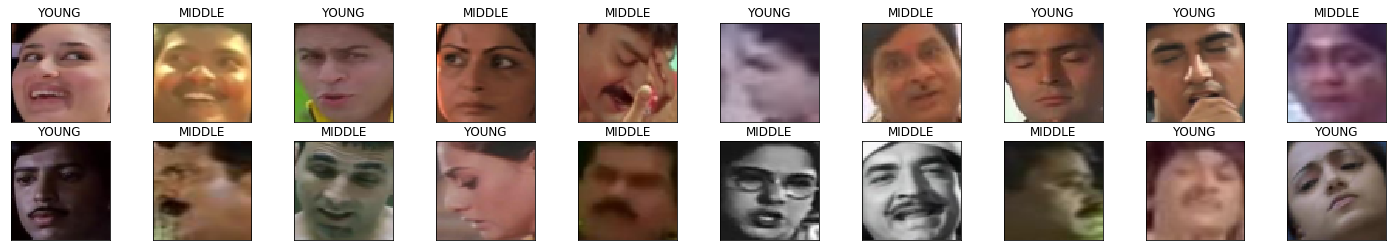

In [220]:
dataiter = iter(train_loader)
images,labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(labels[idx])

In [221]:
[classes[lab] for lab in labels]

[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0]

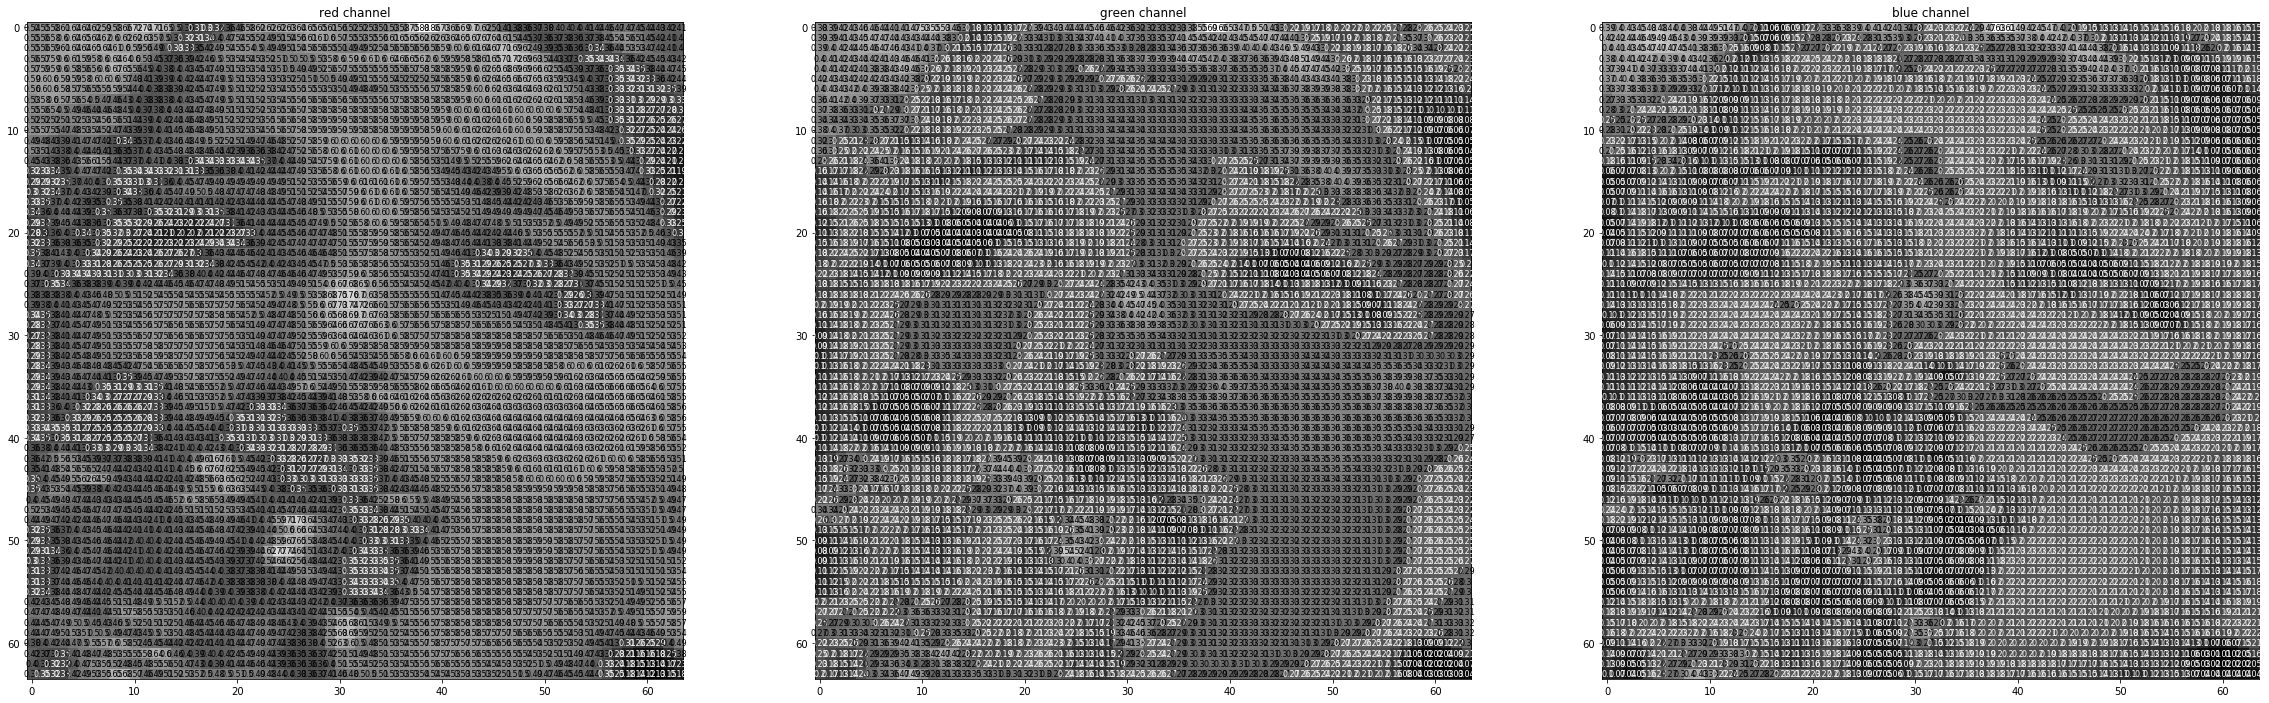

In [181]:
rgb_img = np.squeeze(images[1].numpy())
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (40, 60)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [337]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 64x64x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 32x32x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 16x16x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 3)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        #print(x.size())
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        x = x.view(-1, 128 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)
train_on_gpu = False

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.25)
)


In [338]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [343]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

train_loss_lst=[]
valid_loss_lst=[]

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        target=[classes[lab] for lab in target]
        loss = criterion(output, torch.tensor(target))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        target=[classes[lab] for lab in target]
        loss = criterion(output, torch.tensor(target))
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    
    train_loss = train_loss/len(train_loader.dataset)
    train_loss_lst.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.dataset)
    valid_loss_lst.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss
        
        #es

Epoch: 1 	Training Loss: 0.632141 	Validation Loss: 0.154877
Validation loss decreased (inf --> 0.154877).  Saving model ...
Epoch: 2 	Training Loss: 0.617635 	Validation Loss: 0.150786
Validation loss decreased (0.154877 --> 0.150786).  Saving model ...
Epoch: 3 	Training Loss: 0.603939 	Validation Loss: 0.148396
Validation loss decreased (0.150786 --> 0.148396).  Saving model ...
Epoch: 4 	Training Loss: 0.592258 	Validation Loss: 0.155574
Epoch: 5 	Training Loss: 0.582194 	Validation Loss: 0.144918
Validation loss decreased (0.148396 --> 0.144918).  Saving model ...
Epoch: 6 	Training Loss: 0.570416 	Validation Loss: 0.141300
Validation loss decreased (0.144918 --> 0.141300).  Saving model ...
Epoch: 7 	Training Loss: 0.557566 	Validation Loss: 0.147233
Epoch: 8 	Training Loss: 0.545095 	Validation Loss: 0.137561
Validation loss decreased (0.141300 --> 0.137561).  Saving model ...
Epoch: 9 	Training Loss: 0.534991 	Validation Loss: 0.163370
Epoch: 10 	Training Loss: 0.524739 	Valida

In [324]:
#model = torch.load("./model_augmented.pt")

In [328]:
#conv_model = Net()


In [330]:
conv_model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=3, bias=True)
  (dropout): Dropout(p=0.25)
)

In [353]:
#dataiter = iter(test_loader)
#[""]
def creat_results(model,fl_name):
    lst=['YOUNG','MIDDLE', 'OLD']
    clslst=[]
    for i in range(len(actress_dataset_test)):
        obse=model(actress_dataset_test[i].unsqueeze(0))
        cls=obse.detach().numpy().argmax()
        clslst.append(lst[cls])
    IDS=actress_dataset_test.actress_frame["ID"].values
    df=pd.DataFrame({"Class":clslst,"ID":IDS})
    df.to_csv(fl_name,index=False)

In [345]:
IDS=actress_dataset_test.actress_frame["ID"].values
df=pd.DataFrame({"Class":clslst,"ID":IDS})

In [346]:
df.to_csv("Submission3.csv",index=False)

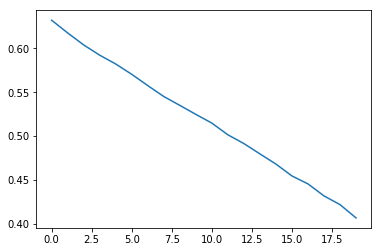

In [347]:
plt.plot(train_loss_lst)

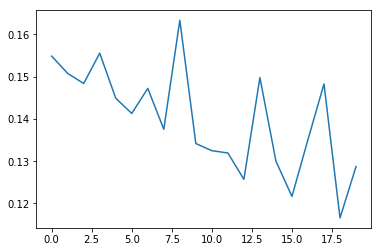

In [348]:
plt.plot(valid_loss_lst)

In [350]:
Old_model = torch.load("./model_augmented.pt")
model2 = Net()
model2.load_state_dict(Old_model)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [354]:
creat_results(model2,"Submission4.csv")